# 3DCORE ABC SMC fitting for Nov 2020 and June 2020 ICME events

output in /results/abc_runs

install from git

https://github.com/ajefweiss/py3DCORE 2.0.1

https://github.com/ajefweiss/HelioSat 0.6.0



In [1]:
import datetime
import heliosat
import logging

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap
from matplotlib import rc

from sunpy.time import parse_time

import numpy as np
import os
import pickle
import py3dcore

from heliosat.util import configure_logging
from py3dcore.fitter import ABC_SMC

from matplotlib import pyplot as plt

configure_logging(debug=False, logfile=None, verbose=True)
logging.getLogger("heliosat.spice").setLevel("WARNING")
logging.getLogger("heliosat.spacecraft").setLevel("WARNING")

print(py3dcore.__version__)
print(heliosat.__version__)

    
import astropy.units as unit 
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames



data_path='/nas/helio/data/insitu_python/'

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/home/cmoestl/miniconda/envs/solo/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


2.0.1
0.6.0


In [2]:
print('load data RTN') 

filepsp='psp_2018_2021_rtn.p'
[pspd,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 
    
filewin="wind_2018_now_heeq.p" 
[wind,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  

filesta='stereoa_2020_now_rtn_beacon.p'
[stad,hsta]=pickle.load(open(data_path+filesta, "rb" ) )  

filebepi='bepi_2019_2021_rtn.p'
bepid=pickle.load(open(data_path+filebepi, "rb" ) ) 

filesolo='solo_2020_april_2021_april_rtn.p'
solod=pickle.load(open(data_path+filesolo, "rb" ) ) 

print('done')

#cutout nov event
ind1=np.where(pspd.time>datetime.datetime(2020,11,30,15))[0][0]
ind2=np.where(pspd.time>datetime.datetime(2020,12,5,15))[0][0]
psp1=pspd[ind1:ind2]

ind1=np.where(stad.time>datetime.datetime(2020,11,30,15))[0][0]
ind2=np.where(stad.time>datetime.datetime(2020,12,5,15))[0][0]
sta1=stad[ind1:ind2]

[psp, bepi, solo, earth, mars, mercury,venus,sta,stb]= \
      pickle.load( open( 'data/positions_HCI_1hr.p', "rb" ))
#convert to mdates
psp_numtime=mdates.date2num(psp.time)
bepi_numtime=mdates.date2num(bepi.time)
solo_numtime=mdates.date2num(solo.time)
sta_numtime=mdates.date2num(sta.time)
earth_numtime=mdates.date2num(earth.time)



load data RTN
done


### Functions

In [3]:
def measure(obj, sat, t0, t1, frame="HEEQ", bframe="HEEQ", satparams=None):
    
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    #time resolution in seconds
    print('t0',t0)
    
    #t_s1 = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    #print('t_s1',t_s1[0],t_s1[-1])
    
    #time resolution in minutes as fraction per day
    res_in_days=1/(60.)    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += datetime.timedelta(days=res_in_days)
        
    print('t_s',t_s[0],t_s[-1])    
    print()
    
    o_s = inst.trajectory(t_s, reference_frame=frame)

    #b = 
    #print(len(t_s), b.shape)

    b = heliosat.transform.transform_reference_frame(t_s, np.array(obj.simulator(t_s, o_s)[0]).reshape(-1, 3), frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b

#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=140, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)

    p=np.arange(0,2*np.pi,0.01)
    r1=1.0
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.8
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.6
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.4
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r1=0.2
    ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    
    
    ax.set_axis_off()
    
       
    



def plot_configure2(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=0, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    #1 AU circle
    p=np.arange(0,2*np.pi,0.01)
    r1=1.0
    ax.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r2=0.72
    ax.plot(r2*np.sin(p),r2*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    r2=0.53
    ax.plot(r2*np.sin(p),r2*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
    
    ax.set_axis_off()

    

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .12)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)  

    obj.propagate(t_snap)
    wf_model = obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs,zorder=3)    
    
   
   
def plot_3dcore_field(ax, obj, step_size=0.005, q0=[1, .1, np.pi/2],**kwargs):

    #initial point is q0
    q0i =np.array(q0, dtype=np.float32).astype(np.float32)    
    fl = obj.visualize_fieldline_dpsi(q0i, dpsi=2*np.pi-0.01, step_size=step_size)
    ax.plot(*fl.T, **kwargs)
    

def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        #ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
        
def plot_shift(axis,extent,cx,cy,cz):
    #shift center of plot
    axis.set_xbound(cx-extent, cx+extent)
    axis.set_ybound(cy-extent, cy+extent)
    axis.set_zbound(cz-extent*0.75, cz+extent*0.75)  

earth_color='blue'
solo_color='orange'
venus_color='mediumseagreen'
mercury_color='grey'
psp_color='black'
sta_color='red'
bepi_color='coral'    




# (1) 2020 Nov 29 CME

In [4]:
dt_0 = datetime.datetime(2020, 11, 29, 15, tzinfo=datetime.timezone.utc)

t_s = datetime.datetime(2020, 12, 1, tzinfo=datetime.timezone.utc)
t_e = datetime.datetime(2020, 12, 1, 10, tzinfo=datetime.timezone.utc)

t_fp = [
    datetime.datetime(2020, 12, 1, 3, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2020, 12, 1, 4, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2020, 12, 1, 5, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2020, 12, 1, 6, 30, tzinfo=datetime.timezone.utc),
    datetime.datetime(2020, 12, 1, 7, 30, tzinfo=datetime.timezone.utc),
]

model_kwargs = {
    "ensemble_size": int(2**18),
    "iparams": {
        "cme_longitude": {
            "maximum": 0,
            "minimum": -120
        },
        "cme_inclination": {
            "maximum": 360,
            "minimum": 180
        }, 
        "cme_launch_velocity": {
            "maximum": 2000,
            "minimum": 800
        },
        "t_factor": {
            "maximum": 120,
            "minimum": 0
        }
    }
}

fitter = ABC_SMC()
fitter.initialize(dt_0, py3dcore.ToroidalModel, model_kwargs)
fitter.add_observer("PSP", t_fp, t_s, t_e)

#possible to add 2nd observer here
a = heliosat.PSP()

In [5]:
fitter.run(5, 512, reference_frame="HCI", jobs=32, workers=32, sampling_freq=3600, output="/home/cmoestl/pycode/solar_orbiter/fits/2020nov29")

2021-09-08 10:41:14,437 - py3dcore.fitter.abc_smc - running iteration 0
2021-09-08 10:41:14,641 - py3dcore.fitter.abc_smc - initial eps_init = [1.16611912]
2021-09-08 10:42:13,348 - py3dcore.fitter.abc_smc - step 0:0 with (1202/512) particles
2021-09-08 10:42:13,357 - py3dcore.fitter.abc_smc - setting new eps: [1.16611912] => [0.87994014]
2021-09-08 10:42:13,359 - py3dcore.fitter.abc_smc - step 0 done, 512 particles, 8.39M runs in 58.92 seconds, (total: 00h 00m 58s)
2021-09-08 10:42:13,436 - py3dcore.fitter.abc_smc - running iteration 1
2021-09-08 10:44:09,483 - py3dcore.fitter.abc_smc - step 1:0 with (6702/512) particles
2021-09-08 10:44:11,436 - py3dcore.fitter.abc_smc - setting new eps: [0.87994014] => [0.69438405]
2021-09-08 10:44:11,437 - py3dcore.fitter.abc_smc - step 1 done, 512 particles, 8.39M runs in 118.00 seconds, (total: 00h 02m 56s)
2021-09-08 10:44:11,579 - py3dcore.fitter.abc_smc - running iteration 2
2021-09-08 10:46:03,050 - py3dcore.fitter.abc_smc - step 2:0 with (12

In [17]:
fit_filename='fits/2020nov29/11.pickle'

fit11=pickle.load(open(fit_filename, "rb" ) )

In [18]:
fit=fit11#['model_obj']

print(fit.keys())
print()

print(fit['model_obj'].__dict__.keys())

print()
print(fit['model_obj'].iparams.keys())

print()
best_fit_ind=np.argmin(fit['hist_eps'])
print(best_fit_ind)



dict_keys(['locked', 'dt_0', 'model_kwargs', 'observers', 'model', 'iter_i', 'hist_eps', 'hist_time', 'hist_eps_dim', 'model_obj', 'data_obj', 'epses'])

dict_keys(['dt_0', 'dt_t', 'iparams', 'sparams', 'ensemble_size', 'dtype', 'iparams_arr', 'iparams_kernel', 'iparams_weight', 'iparams_kernel_decomp', 'sparams_arr', 'qs_sx', 'qs_xs', 'iparams_meta', 'mag_model', 'shape_model'])

dict_keys(['cme_launch_offset', 'cme_longitude', 'cme_latitude', 'cme_inclination', 'cme_diameter_1au', 'cme_aspect_ratio', 'cme_launch_radius', 'cme_launch_velocity', 't_factor', 'cme_expansion_rate', 'magnetic_decay_rate', 'magnetic_field_strength_1au', 'background_drag', 'background_velocity'])

13


In [19]:
model=fit['model'](fit['dt_0'],1)


parr=fit['model_obj'].iparams_arr

model.update_iparams(parr[best_fit_ind].reshape(1,-1))

t_launch=fit['dt_0']

TP_A =  t_launch + datetime.timedelta(hours=24)
print(TP_A)

2020-11-30 15:00:00+00:00


In [20]:
print('3DCORE parameters in HCI \n ')

param_names=['cme_launch_offset', 'cme_longitude', 
             'cme_latitude', 'cme_inclination', 'cme_diameter_1au', 
             'cme_aspect_ratio', 'cme_launch_radius', 'cme_launch_velocity',
             't_factor', 'cme_expansion_rate', 'magnetic_decay_rate', 
             'magnetic_field_strength_1au', 'background_drag', 'background_velocity']

param_values=model.iparams_arr[0]

param_std=np.std(py3dcore.BaseFitter(fit_filename).model_obj.iparams_arr, axis=0)

for i in np.arange(len(param_names)):
    print(param_names[i], np.round(param_values[i],2), '+/-', np.round(param_std[i],2) )
    
print()    
#convert direction from HCI to HEEQ   
#https://docs.sunpy.org/en/stable/code_ref/coordinates/index.html
    
dir_hci = SkyCoord(param_values[1]*unit.deg, param_values[2]*unit.deg, obstime=t_launch, frame=frames.HeliocentricInertial)
dir_heeq = dir_hci.transform_to(frames.HeliographicStonyhurst)

print('Direction in HEEQ lon / lat: ', np.round(dir_heeq.lon.value,2), np.round(dir_heeq.lat.value,2) )




3DCORE parameters in HCI 
 
cme_launch_offset 0.0 +/- 0.0
cme_longitude -93.5 +/- 5.22
cme_latitude 17.79 +/- 6.2
cme_inclination 264.56 +/- 5.54
cme_diameter_1au 0.11 +/- 0.01
cme_aspect_ratio 11.14 +/- 0.95
cme_launch_radius 20.0 +/- 0.0
cme_launch_velocity 1466.05 +/- 198.48
t_factor 41.16 +/- 12.58
cme_expansion_rate 1.14 +/- 0.0
magnetic_decay_rate 1.64 +/- 0.0
magnetic_field_strength_1au 21.67 +/- 1.22
background_drag 0.23 +/- 0.04
background_velocity 364.21 +/- 17.12

Direction in HEEQ lon / lat:  -85.37 17.79


In [21]:
t2, btot2, bxyz2 = measure(model, "PSP", t_launch, t_launch  + datetime.timedelta(hours=96), frame="HCI", bframe="SPP_RTN")

t0 2020-11-29 15:00:00+00:00
t_s 2020-11-29 15:00:00+00:00 2020-12-03 14:36:00+00:00



In [22]:
ensemble_data = py3dcore.fitter.generate_ensemble('fits/2020nov29/11.pickle', t2, reference_frame="SPP_RTN", max_index=16, perc=0.66)

/home/cmoestl/pycode/py3DCORE/py3dcore/fitter/base.py:40: RuntimeWarning: Mean of empty slice
  b_m = np.nanmean(ensemble, axis=1)
/home/cmoestl/miniconda/envs/solo/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/cmoestl/pycode/py3DCORE/py3dcore/fitter/base.py:46: RuntimeWarning: Mean of empty slice
  b_tm = np.nanmean(b_t, axis=1)


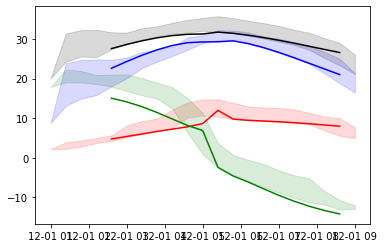

In [23]:
sta_ensemble = ensemble_data[0]

(_, _, (psp_b_s2p, psp_b_s2n), (psp_b_ts2p, psp_b_ts2n)) = sta_ensemble


plt.plot(t2,bxyz2[:,0],'r')
plt.plot(t2,bxyz2[:,1],'g')
plt.plot(t2,bxyz2[:,2],'b')

plt.plot(t2,btot2,'k')

plt.fill_between(t2, psp_b_s2p[:, 0], psp_b_s2n[:, 0], color="r", alpha=0.15)
plt.fill_between(t2, psp_b_s2p[:, 1], psp_b_s2n[:, 1], color="g", alpha=0.15)
plt.fill_between(t2, psp_b_s2p[:, 2], psp_b_s2n[:, 2], color="b", alpha=0.15)

plt.fill_between(t2, psp_b_ts2p, psp_b_ts2n, color="k", alpha=0.15)

## figure nov event with fit

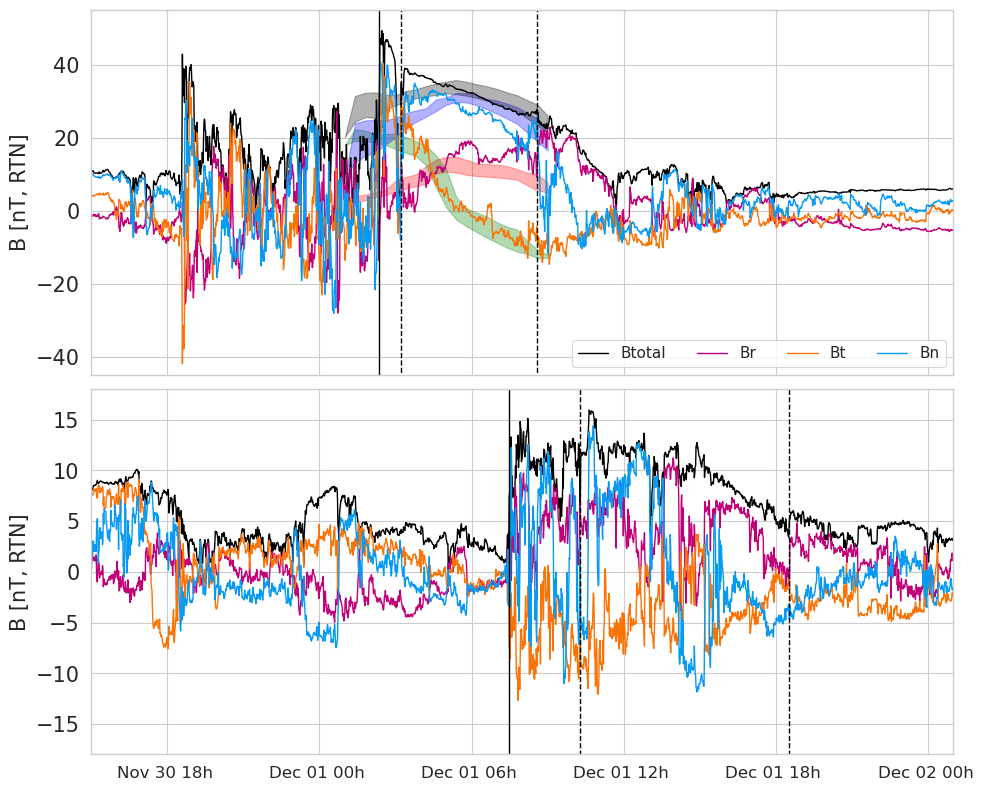

In [24]:
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(10, 8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((2, 1), (0, 0))  
ax2 = plt.subplot2grid((2, 1), (1, 0))  

## PSP
plotstart=datetime.datetime(2020,11,30,15)
plotend=datetime.datetime(2020,12,2,1)
blim=55


ax1.plot(psp1.time, psp1.bt, "k-", lw=1,label='Btotal')
ax1.plot(psp1.time, psp1.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(psp1.time, psp1.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(psp1.time, psp1.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
    
    
ax1.fill_between(t2, psp_b_s2p[:, 0], psp_b_s2n[:, 0], color="r", alpha=0.3)
ax1.fill_between(t2, psp_b_s2p[:, 1], psp_b_s2n[:, 1], color="g", alpha=0.3)
ax1.fill_between(t2, psp_b_s2p[:, 2], psp_b_s2n[:, 2], color="b", alpha=0.3)
ax1.fill_between(t2, psp_b_ts2p, psp_b_ts2n, color="k", alpha=0.3)


#from ICMECAT
picme_start_time=parse_time('2020-12-01 02:22').datetime
pmo_start_time=parse_time('2020-12-01 03:13').datetime
pmo_end_time=parse_time('2020-12-01 08:34' ).datetime

#plot vertical lines
ax1.plot_date([picme_start_time,picme_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([pmo_start_time,pmo_start_time],[-500,500],'--k',linewidth=1)            
ax1.plot_date([pmo_end_time,pmo_end_time],[-500,500],'--k',linewidth=1)    

#0 line
#ax1.plot_date([plotstart,plotend],[0,0],'-k',linewidth=1,alpha=0.1)    



ax1.set_ylabel('B [nT, RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim+10,blim)
ax1.legend(loc=4,ncol=4,fontsize=11)
ax1.grid(True)
ax1.set_xticklabels([])
ax1.tick_params(axis='y', labelsize=15)
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/4))


### STA
blim=18
ax2.plot(sta1.time, sta1.bt, "k-", lw=1,label='Btotal')
ax2.plot(sta1.time, sta1.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax2.plot(sta1.time, sta1.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax2.plot(sta1.time, sta1.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
ax2.set_ylabel('B [nT, RTN]',fontsize=15)
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax2.grid(True)
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/4))


#from ICMECAT
sicme_start_time=parse_time('2020-12-01 07:28').datetime
smo_start_time=parse_time('2020-12-01 10:17').datetime
smo_end_time=parse_time('2020-12-01 18:30' ).datetime



#plot vertical lines
ax2.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([smo_start_time,smo_start_time],[-500,500],'--k',linewidth=1)            
ax2.plot_date([smo_end_time,smo_end_time],[-500,500],'--k',linewidth=1)    

#0 line
#ax2.plot_date([plotstart,plotend],[0,0],'-k',linewidth=1,alpha=0.1)    




plt.tight_layout()

plt.savefig('results/2020_nov_29/figure_psp_sta_2020_nov_event.png')
plt.savefig('results/2020_nov_29/figure_psp_sta_2020_nov_event.pdf')

In [25]:
## fit only PSP panel close up

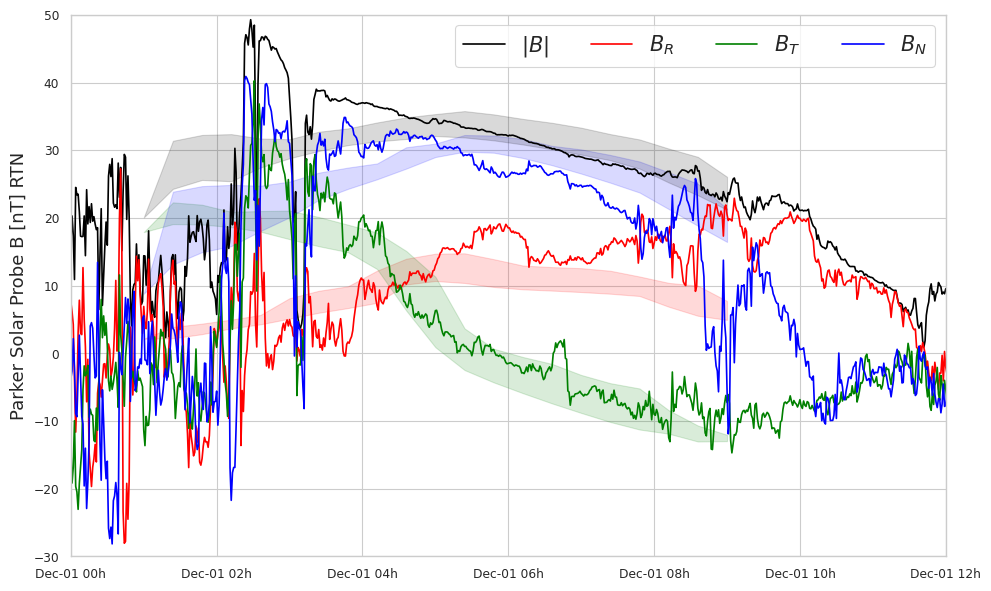

In [26]:
sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(10, 6),dpi=100)

ax1 = plt.subplot2grid((1, 1), (0, 0)) 

ax1.plot(psp1.time,psp1.bt,'k',label="$|B|$")
ax1.plot(psp1.time,psp1.bx,'r',label="$B_R$")
ax1.plot(psp1.time,psp1.by,'g',label="$B_T$")
ax1.plot(psp1.time,psp1.bz,'b',label="$B_N$")
plotstart=datetime.datetime(2020,12,1,0)
plotend=datetime.datetime(2020,12,1,12)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim([-30, 50])
ax1.set_ylabel('Parker Solar Probe B [nT] RTN',fontsize=13)
ax1.legend(loc=1,ncol=4,fontsize=15)


fmt = mdates.DateFormatter('%b-%d %Hh')
ax1.xaxis.set_major_formatter(fmt)

ax1.fill_between(t2, psp_b_s2p[:, 0], psp_b_s2n[:, 0], color="r", alpha=0.15)
ax1.fill_between(t2, psp_b_s2p[:, 1], psp_b_s2n[:, 1], color="g", alpha=0.15)
ax1.fill_between(t2, psp_b_s2p[:, 2], psp_b_s2n[:, 2], color="b", alpha=0.15)
ax1.fill_between(t2, psp_b_ts2p, psp_b_ts2n, color="k", alpha=0.15)




plt.tight_layout()

plt.savefig('results/2020_nov_29/2020_nov_29_3dcore_fit_zoom.png')
plt.savefig('results/2020_nov_29/2020_nov_29_3dcore_fit_zoom.pdf')

### 3D plots


current frame_time_num 2020-12-01 01:00:00+00:00


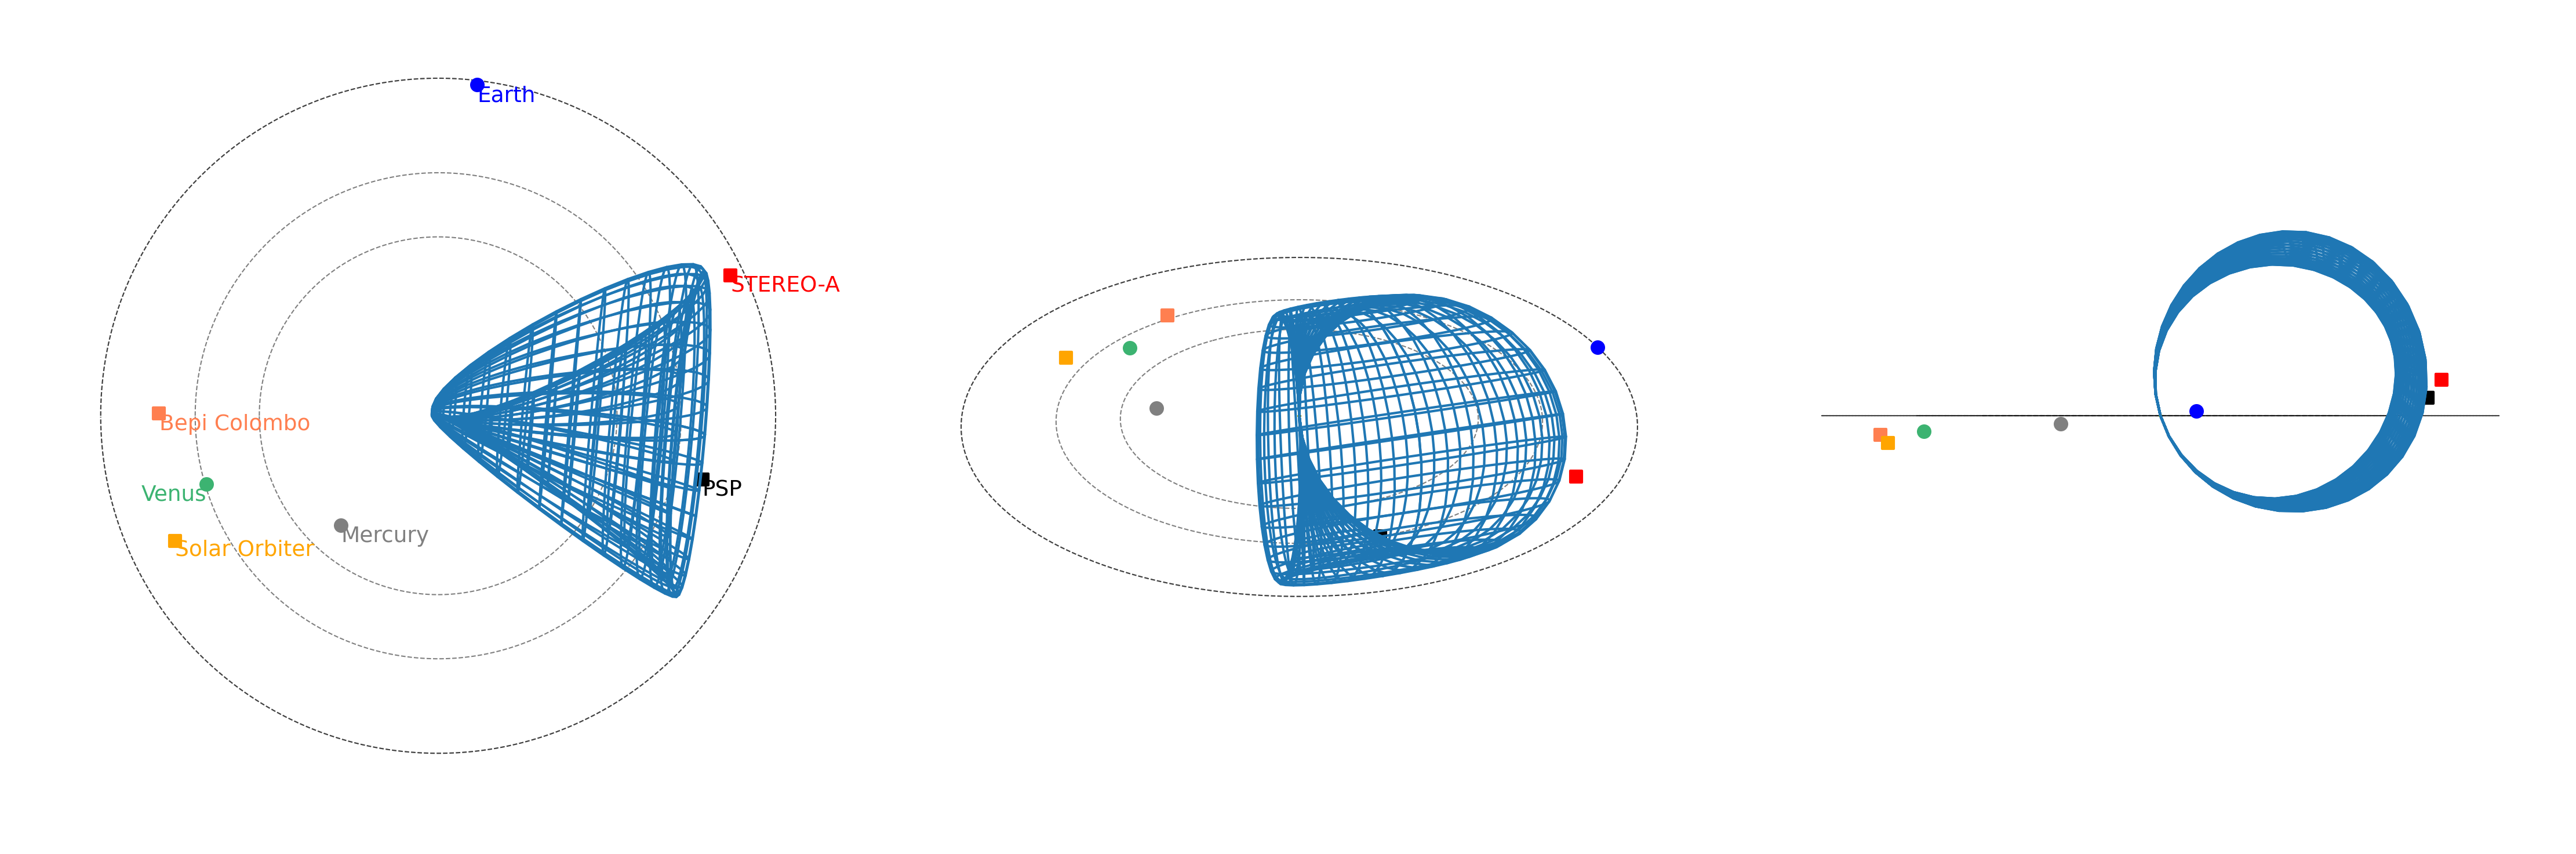

In [27]:
sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(15, 5),dpi=300)

#define subplot grid
ax1 = plt.subplot2grid((1, 3), (0, 0),projection='3d')  
ax2 = plt.subplot2grid((1, 3), (0, 1),projection='3d')  
ax3 = plt.subplot2grid((1, 3), (0, 2),projection='3d')  

TP_C =  datetime.datetime(2020,12,1,1,0,0)


model.propagator(TP_C)
vis=model.visualize_shape()



frame_time_num=mdates.date2num(TP_C) 
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-psp_numtime
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-bepi_numtime
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-solo_numtime
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-sta_numtime
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-earth_numtime
earth_timeind=np.argmin(abs(dct))


########### top view panel
plot_configure2(ax1, view_azim=180, view_elev=90, view_radius=.75)
#plot_3dcore(ax1, model_obj, TP_C, color=C_B)
#plot_3dcore(ax1, model_obj2, TP_C, color='black')

ax1.plot_wireframe(*vis.T,'-b',linewidth=1)

#plot_3dcore_field(ax2, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)

plot_traj(ax1, "Earth", TP_C, frame="HCI", color=earth_color)
plot_traj(ax1, "Venus", TP_C, frame="HCI", color=venus_color)
plot_traj(ax1, "Mercury", TP_C, frame="HCI", color=mercury_color)
plot_traj(ax1, "SOLO", TP_C, frame="HCI", color=solo_color,marker='s')
plot_traj(ax1, "PSP", TP_C, frame="HCI", color=psp_color,marker='s')
plot_traj(ax1, "STA", TP_C, frame="HCI", color=sta_color,marker='s')
plot_traj(ax1, "BEPI", TP_C, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax2,0.62,-0.2,0.2,0)


######### tilted view
plot_configure2(ax2, view_azim=240, view_elev=30, view_radius=.75)
ax2.plot_wireframe(*vis.T,'-b',linewidth=1)
#plot_3dcore(ax2, model_obj, TP_C, color=C_B)
#plot_3dcore(ax2, model_obj2, TP_C, color='black')

#plot_3dcore_field(ax1, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)
#plot_3dcore_field(ax1, model_obj, color=C_B, step_size=0.005, lw=1.1, ls="-",q0=np.array([0.5, .1, np.pi/2]))

plot_traj(ax2, "Earth", TP_C, frame="HCI", color=earth_color)
plot_traj(ax2, "Venus", TP_C, frame="HCI", color=venus_color)
plot_traj(ax2, "Mercury", TP_C, frame="HCI", color=mercury_color)
plot_traj(ax2, "SOLO", TP_C, frame="HCI", color=solo_color,marker='s')
plot_traj(ax2, "PSP", TP_C, frame="HCI", color=psp_color,marker='s')
plot_traj(ax2, "STA", TP_C, frame="HCI", color=sta_color,marker='s')
plot_traj(ax2, "BEPI", TP_C, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax1,0.3,-0.5,0.5,0)

############### edge on view panel
plot_configure2(ax3, view_azim=180, view_elev=0, view_radius=.75)
ax3.plot_wireframe(*vis.T,'-b',linewidth=1)
#plot_3dcore(ax3, model_obj, TP_C, color=C_B)
#plot_3dcore(ax3, model_obj2, TP_C, color='black')

#plot_3dcore_field(ax3, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)


plot_traj(ax3, "Earth", TP_C, frame="HCI", color=earth_color)
plot_traj(ax3, "Venus", TP_C, frame="HCI", color=venus_color)
plot_traj(ax3, "Mercury", TP_C, frame="HCI", color=mercury_color)
plot_traj(ax3, "SOLO", TP_C, frame="HCI", color=solo_color,marker='s')
plot_traj(ax3, "PSP", TP_C, frame="HCI", color=psp_color,marker='s')
plot_traj(ax3, "STA", TP_C, frame="HCI", color=sta_color,marker='s')
plot_traj(ax3, "BEPI", TP_C, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax3,0.4,-0.2,0.2,0)



#1 AU circle
p=np.arange(0,2*np.pi,0.01)
r1=1.0
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax2.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax3.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

#panel labels
#plt.annotate('(a)',[0.00,0.93],xycoords='figure fraction',fontsize=20)
#plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
#plt.annotate('(c)',[0.69,0.32],xycoords='figure fraction',fontsize=20)
#plt.annotate('(d)',[0.00,0.32],xycoords='figure fraction',fontsize=20)
#plt.annotate('(e)',[0.345,0.32],xycoords='figure fraction',fontsize=20)


#current time
#plt.annotate(parse_time(TP_C).iso[0:16]+' UT',[0.55,0.9],ha='center',xycoords='figure fraction',fontsize=15)


#planet and spacecraft labels
fsize=13

ax1.text(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(solo.x[solo_timeind],solo.y[solo_timeind],solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind],'Venus', color=venus_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax1.text(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='left',fontsize=fsize-4,verticalalignment='top')

ax1.text(psp.x[psp_timeind],psp.y[psp_timeind],psp.z[psp_timeind],'PSP', color=psp_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(bepi.x[bepi_timeind],bepi.y[bepi_timeind],bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(sta.x[sta_timeind],sta.y[sta_timeind],sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='left',fontsize=fsize-4,verticalalignment='top')

#plt.annotate(parse_time(t_launch).iso[0:16],[0.55,0.35],ha='center',xycoords='figure fraction',fontsize=20)

plt.tight_layout()
plt.savefig('results/2020_nov_29/2020_nov_29_3vis.png',bbox_inches='tight')
plt.savefig('results/2020_nov_29/2020_nov_29_3vis.pdf',bbox_inches='tight')




# (2) 2020 Jun 23 CME

In [51]:
#cutout jun event
ind1=np.where(pspd.time>datetime.datetime(2020,6,20,15))[0][0]
ind2=np.where(pspd.time>datetime.datetime(2020,7,10,15))[0][0]
psp2=pspd[ind1:ind2]
ind1=np.where(wind.time>datetime.datetime(2020,6,20,15))[0][0]
ind2=np.where(wind.time>datetime.datetime(2020,7,10,15))[0][0]
win2=wind[ind1:ind2]
ind1=np.where(bepid.time>datetime.datetime(2020,6,20,15))[0][0]
ind2=np.where(bepid.time>datetime.datetime(2020,7,10,15))[0][0]
bepi2=bepid[ind1:ind2]

In [52]:
fit_filename='fits/2020jun23/06.pickle'

fitj1=pickle.load(open(fit_filename, "rb" ) )

In [53]:
fitj=fitj1#['model_obj']

print(fitj.keys())
print()

print(fitj['model_obj'].__dict__.keys())

print()
print(fitj['model_obj'].iparams.keys())

print()
best_fit_ind=np.argmin(fitj['hist_eps'])
print(best_fit_ind)



dict_keys(['locked', 'dt_0', 'model_kwargs', 'observers', 'model', 'iter_i', 'hist_eps', 'hist_time', 'hist_eps_dim', 'model_obj', 'data_obj', 'epses'])

dict_keys(['dt_0', 'dt_t', 'iparams', 'sparams', 'ensemble_size', 'dtype', 'iparams_arr', 'iparams_kernel', 'iparams_weight', 'iparams_kernel_decomp', 'sparams_arr', 'qs_sx', 'qs_xs', 'iparams_meta', 'mag_model', 'shape_model'])

dict_keys(['cme_launch_offset', 'cme_longitude', 'cme_latitude', 'cme_inclination', 'cme_diameter_1au', 'cme_aspect_ratio', 'cme_launch_radius', 'cme_launch_velocity', 't_factor', 'cme_expansion_rate', 'magnetic_decay_rate', 'magnetic_field_strength_1au', 'background_drag', 'background_velocity'])

8


In [54]:
model=fitj['model'](fitj['dt_0'],1)


parr=fitj['model_obj'].iparams_arr

model.update_iparams(parr[best_fit_ind].reshape(1,-1))

t_launch=fitj['dt_0']

TP_A =  t_launch + datetime.timedelta(hours=24)
print(TP_A)

2020-06-24 02:00:00+00:00


In [55]:
print('3DCORE parameters in HCI \n ')

param_names=['cme_launch_offset', 'cme_longitude', 
             'cme_latitude', 'cme_inclination', 'cme_diameter_1au', 
             'cme_aspect_ratio', 'cme_launch_radius', 'cme_launch_velocity',
             't_factor', 'cme_expansion_rate', 'magnetic_decay_rate', 
             'magnetic_field_strength_1au', 'background_drag', 'background_velocity']

param_values=model.iparams_arr[0]

param_std=np.std(py3dcore.BaseFitter(fit_filename).model_obj.iparams_arr, axis=0)

for i in np.arange(len(param_names)):
    print(param_names[i], np.round(param_values[i],2), '+/-', np.round(param_std[i],2) )
    
print()    
#convert direction from HCI to HEEQ   
#https://docs.sunpy.org/en/stable/code_ref/coordinates/index.html
    
dir_hci = SkyCoord(param_values[1]*unit.deg, param_values[2]*unit.deg, obstime=t_launch, frame=frames.HeliocentricInertial)
dir_heeq = dir_hci.transform_to(frames.HeliographicStonyhurst)

print('Direction in HEEQ lon / lat: ', np.round(dir_heeq.lon.value,2), np.round(dir_heeq.lat.value,2) )



#lon_lat_heeq = heliosat.transform.transform_reference_frame(t_launch, param_values[1:4], "HCI", "HEEQ")
#print(lon_lat_heeq)

3DCORE parameters in HCI 
 
cme_launch_offset 0.0 +/- 0.0
cme_longitude -125.84 +/- 14.25
cme_latitude 6.74 +/- 8.23
cme_inclination 146.07 +/- 10.67
cme_diameter_1au 0.19 +/- 0.02
cme_aspect_ratio 3.07 +/- 0.91
cme_launch_radius 20.0 +/- 0.0
cme_launch_velocity 336.77 +/- 43.52
t_factor 57.78 +/- 19.5
cme_expansion_rate 1.14 +/- 0.0
magnetic_decay_rate 1.64 +/- 0.0
magnetic_field_strength_1au 9.73 +/- 2.05
background_drag 0.86 +/- 0.47
background_velocity 260.09 +/- 46.46

Direction in HEEQ lon / lat:  38.24 6.74


In [56]:
#np.std(model.iparams_arr, axis=0)

In [57]:
t2, btot2, bxyz2 = measure(model, "PSP", t_launch, t_launch  + datetime.timedelta(hours=96), frame="HCI", bframe="SPP_RTN")

t0 2020-06-23 02:00:00+00:00
t_s 2020-06-23 02:00:00+00:00 2020-06-27 01:36:00+00:00



In [58]:
ensemble_data = py3dcore.fitter.generate_ensemble(fit_filename, t2, reference_frame="SPP_RTN", max_index=128, perc=0.66)
sta_ensemble = ensemble_data[0]
(_, _, (psp_b_s2p, psp_b_s2n), (psp_b_ts2p, psp_b_ts2n)) = sta_ensemble

(18438.166666666668, 18439.666666666668)

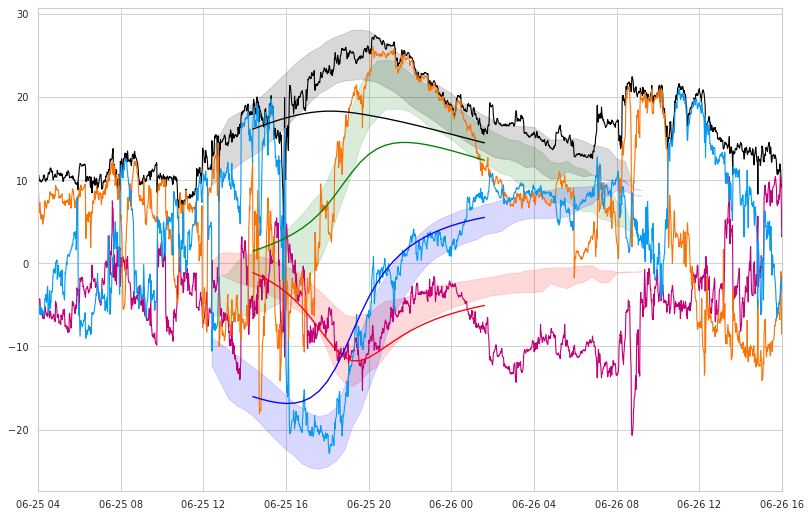

In [60]:

plt.figure(1,figsize=(12, 8),dpi=80)

plotstart=datetime.datetime(2020,6,25,4)
plotend=datetime.datetime(2020,6,26,16)
plt.plot(psp2.time, psp2.bt, "k-", lw=1,label='Btotal')
plt.plot(psp2.time, psp2.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
plt.plot(psp2.time, psp2.by, "g-", color="xkcd:orange", lw=1,label='Bt')
plt.plot(psp2.time, psp2.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    


plt.plot(t2,bxyz2[:,0],'r')
plt.plot(t2,bxyz2[:,1],'g')
plt.plot(t2,bxyz2[:,2],'b')

plt.plot(t2,btot2,'k')

plt.fill_between(t2, psp_b_s2p[:, 0], psp_b_s2n[:, 0], color="r", alpha=0.15)
plt.fill_between(t2, psp_b_s2p[:, 1], psp_b_s2n[:, 1], color="g", alpha=0.15)
plt.fill_between(t2, psp_b_s2p[:, 2], psp_b_s2n[:, 2], color="b", alpha=0.15)

plt.fill_between(t2, psp_b_ts2p, psp_b_ts2n, color="k", alpha=0.15)

plt.xlim(plotstart,plotend)

## figure jun event with fit

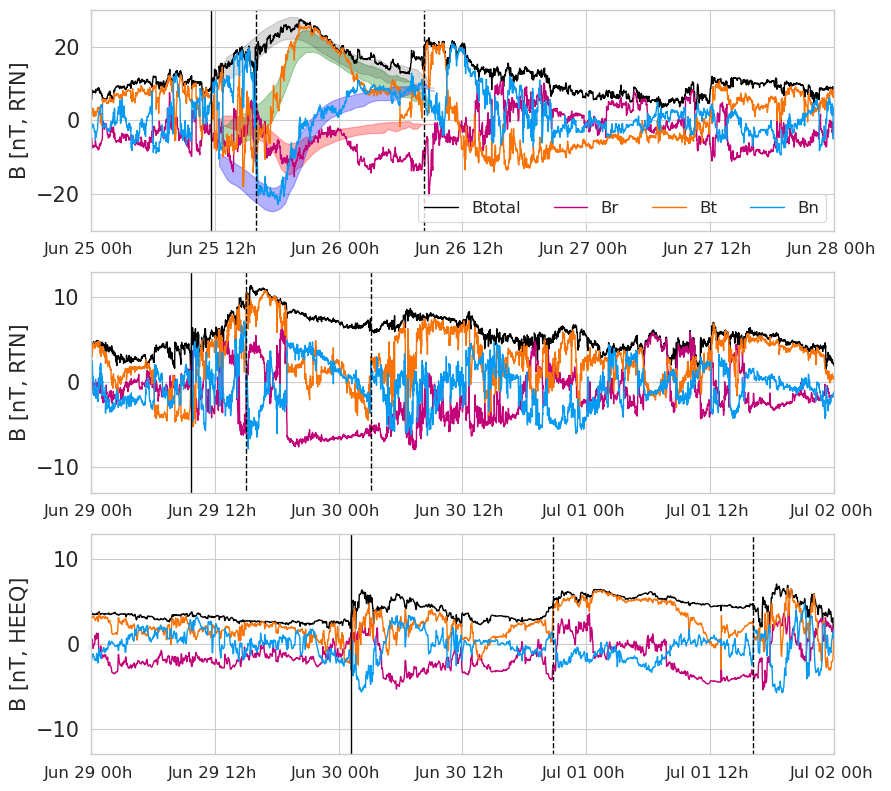

In [63]:
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(1,figsize=(9, 8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((3, 1), (0, 0))  
ax2 = plt.subplot2grid((3, 1), (1, 0))  
ax3 = plt.subplot2grid((3, 1), (2, 0))  



## PSP
plotstart=datetime.datetime(2020,6,25)
plotend=datetime.datetime(2020,6,28)
blim=30


ax1.plot(psp2.time, psp2.bt, "k-", lw=1,label='Btotal')
ax1.plot(psp2.time, psp2.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(psp2.time, psp2.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(psp2.time, psp2.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
shade=0.3
ax1.fill_between(t2, psp_b_s2p[:, 0], psp_b_s2n[:, 0], color="r", alpha=shade)
ax1.fill_between(t2, psp_b_s2p[:, 1], psp_b_s2n[:, 1], color="g", alpha=shade)
ax1.fill_between(t2, psp_b_s2p[:, 2], psp_b_s2n[:, 2], color="b", alpha=shade)
ax1.fill_between(t2, psp_b_ts2p, psp_b_ts2n, color="k", alpha=0.15)




    
#plot vertical lines
#ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
#ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]',fontsize=15)
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim,blim)
ax1.legend(loc=4,ncol=4,fontsize=12)
ax1.grid(True)
ax1.tick_params(axis='y', labelsize=15)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/2))
ax1.tick_params(axis='x', labelsize=12)

### Bepi
blim=13

plotstart=datetime.datetime(2020,6,29)
plotend=datetime.datetime(2020,7,2)


ax2.plot(bepi2.time, bepi2.bt, "k-", lw=1,label='Btotal')
ax2.plot(bepi2.time, bepi2.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax2.plot(bepi2.time, bepi2.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax2.plot(bepi2.time, bepi2.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
ax2.set_ylabel('B [nT, RTN]',fontsize=15)
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax2.grid(True)
ax2.set_xticklabels([])
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/2))


### Wind
blim=13
plotstart=datetime.datetime(2020,6,29)
plotend=datetime.datetime(2020,7,2)


ax3.plot(win2.time, win2.bt, "k-", lw=1,label='Btotal')
ax3.plot(win2.time, win2.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax3.plot(win2.time, win2.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax3.plot(win2.time, win2.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
ax3.set_ylabel('B [nT, HEEQ]',fontsize=15)
ax3.set_xlim(plotstart,plotend)
ax3.set_ylim(-blim,blim)
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=15)
#ax2.legend(loc=1,ncol=4,fontsize=15)
ax3.grid(True)
ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh ') )
ax3.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1/2))



#from ICMECAT
#psp
picme_start_time=parse_time('2020-06-25 11:39').datetime #new 2020-06-25T11:39Z
pmo_start_time=parse_time('2020-06-25 15:59').datetime
pmo_end_time=parse_time('2020-06-26 08:15' ).datetime
#plot vertical lines
ax1.plot_date([picme_start_time,picme_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([pmo_start_time,pmo_start_time],[-500,500],'--k',linewidth=1)            
ax1.plot_date([pmo_end_time,pmo_end_time],[-500,500],'--k',linewidth=1)    


#bepi

bicme_start_time=parse_time('2020-06-29 09:44').datetime
bmo_start_time=parse_time('2020-06-29 15:02').datetime #new 2020-06-29T15:02Z 
bmo_end_time=parse_time('2020-06-30 03:07' ).datetime
#plot vertical lines
ax2.plot_date([bicme_start_time,bicme_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([bmo_start_time,bmo_start_time],[-500,500],'--k',linewidth=1)            
ax2.plot_date([bmo_end_time,bmo_end_time],[-500,500],'--k',linewidth=1)    



#Wind
wicme_start_time=parse_time('2020-06-30 01:12').datetime # new2020-06-30T01:12Z
wmo_start_time=parse_time('2020-06-30 20:48').datetime # new 2020-06-30T20:48Z
wmo_end_time=parse_time('2020-07-01 16:10' ).datetime
#plot vertical lines
ax3.plot_date([wicme_start_time,wicme_start_time],[-500,500],'-k',linewidth=1)            
ax3.plot_date([wmo_start_time,wmo_start_time],[-500,500],'--k',linewidth=1)            
ax3.plot_date([wmo_end_time,wmo_end_time],[-500,500],'--k',linewidth=1)    



plt.tight_layout()

plt.savefig('results/2020_jun_23/figure_2020_jun_event.png')
plt.savefig('results/2020_jun_23/figure_2020_jun_event.pdf')




## 3D plots

current frame_time_num 2020-06-25 07:00:00+00:00


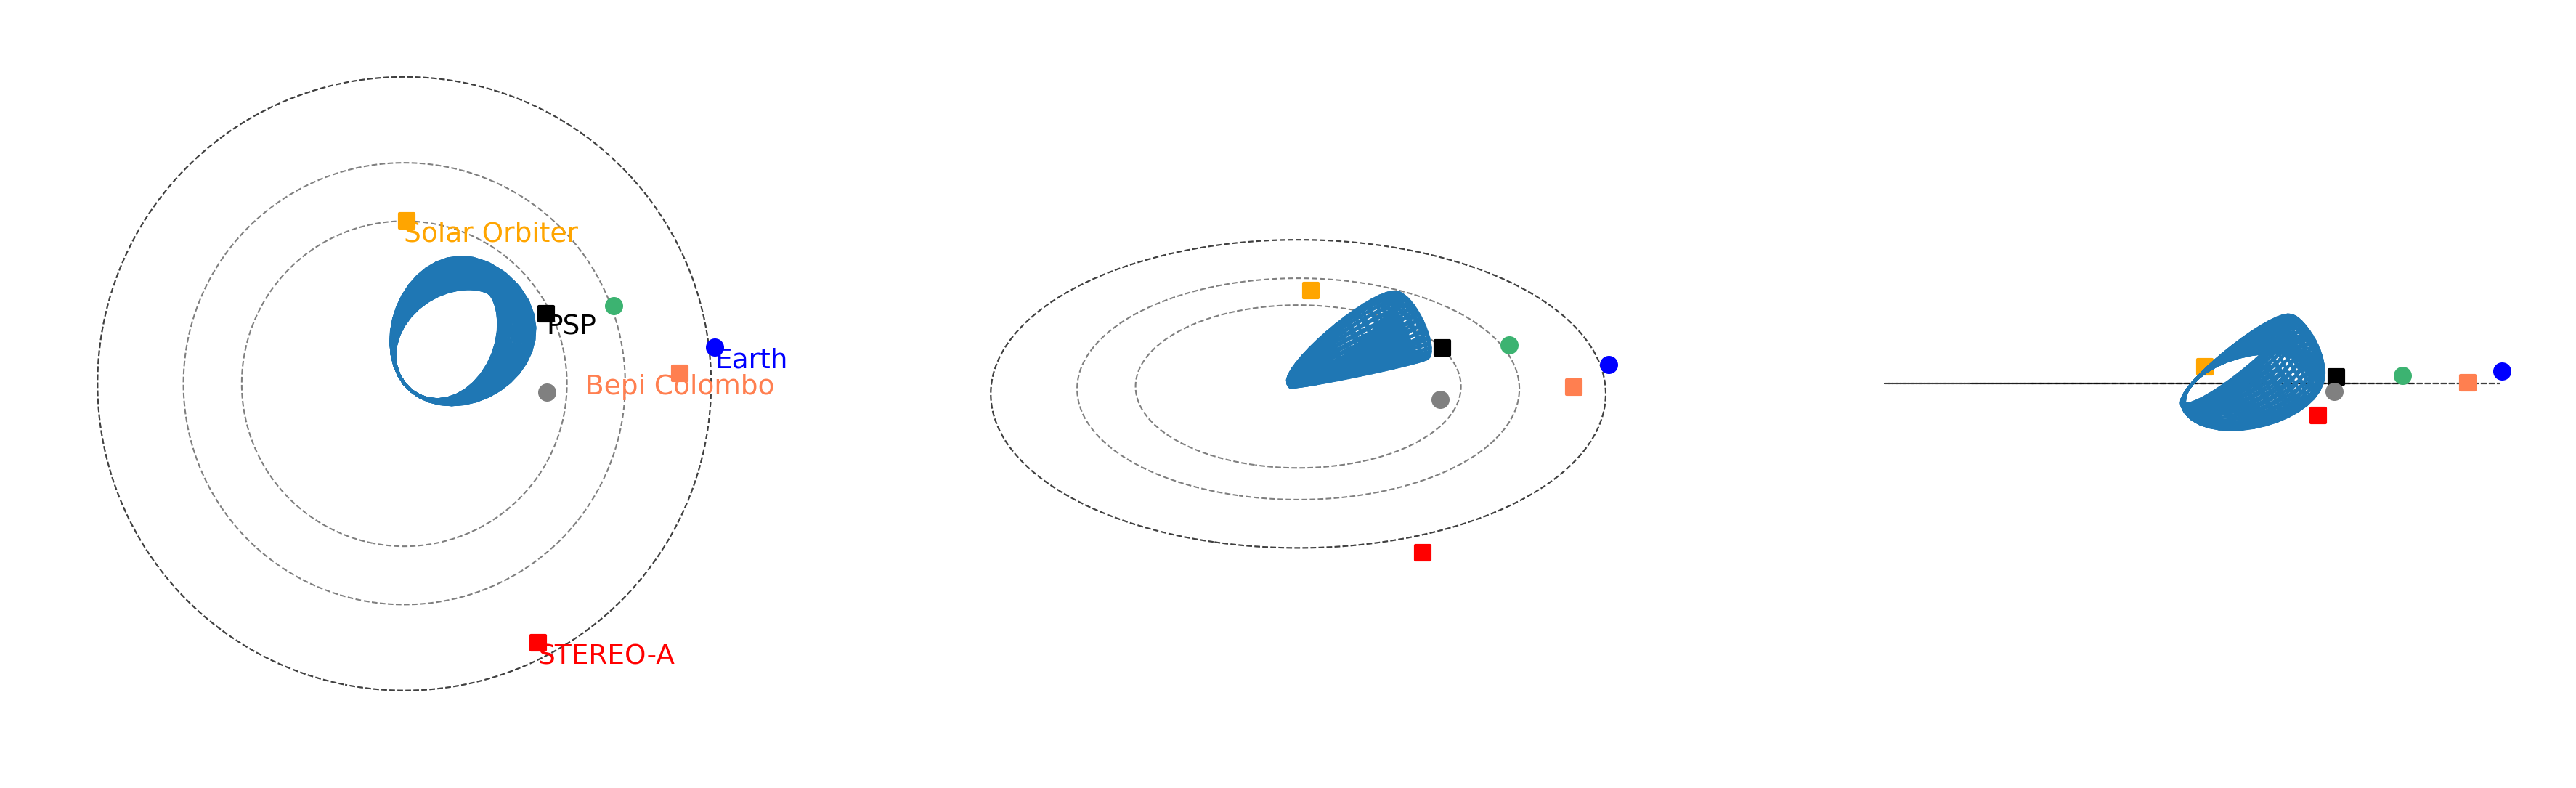

In [64]:
sns.set_style('whitegrid')
fig = plt.figure(1,figsize=(15, 5),dpi=300)

#define subplot grid
ax1 = plt.subplot2grid((1, 3), (0, 0),projection='3d')  
ax2 = plt.subplot2grid((1, 3), (0, 1),projection='3d')  
ax3 = plt.subplot2grid((1, 3), (0, 2),projection='3d')  

TP_C =  datetime.datetime(2020,6,25,7,0,0)


model.propagator(TP_C)
vis=model.visualize_shape()



frame_time_num=mdates.date2num(TP_C) 
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-psp_numtime
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-bepi_numtime
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-solo_numtime
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-sta_numtime
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-earth_numtime
earth_timeind=np.argmin(abs(dct))


azim1=105
azim2=105
azim3=105

########### top view panel
plot_configure2(ax1, view_azim=azim1, view_elev=90, view_radius=.75)
#plot_3dcore(ax1, model_obj, TP_C, color=C_B)
#plot_3dcore(ax1, model_obj2, TP_C, color='black')

ax1.plot_wireframe(*vis.T,'-b',linewidth=1)

#plot_3dcore_field(ax2, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)

plot_traj(ax1, "Earth", TP_C, frame="HCI", color=earth_color)
plot_traj(ax1, "Venus", TP_C, frame="HCI", color=venus_color)
plot_traj(ax1, "Mercury", TP_C, frame="HCI", color=mercury_color)
plot_traj(ax1, "SOLO", TP_C, frame="HCI", color=solo_color,marker='s')
plot_traj(ax1, "PSP", TP_C, frame="HCI", color=psp_color,marker='s')
plot_traj(ax1, "STA", TP_C, frame="HCI", color=sta_color,marker='s')
plot_traj(ax1, "BEPI", TP_C, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax2,0.62,-0.2,0.2,0)


######### tilted view
plot_configure2(ax2, view_azim=azim2, view_elev=30, view_radius=.75)
ax2.plot_wireframe(*vis.T,'-b',linewidth=1)
#plot_3dcore(ax2, model_obj, TP_C, color=C_B)
#plot_3dcore(ax2, model_obj2, TP_C, color='black')

#plot_3dcore_field(ax1, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)
#plot_3dcore_field(ax1, model_obj, color=C_B, step_size=0.005, lw=1.1, ls="-",q0=np.array([0.5, .1, np.pi/2]))

plot_traj(ax2, "Earth", TP_C, frame="HCI", color=earth_color)
plot_traj(ax2, "Venus", TP_C, frame="HCI", color=venus_color)
plot_traj(ax2, "Mercury", TP_C, frame="HCI", color=mercury_color)
plot_traj(ax2, "SOLO", TP_C, frame="HCI", color=solo_color,marker='s')
plot_traj(ax2, "PSP", TP_C, frame="HCI", color=psp_color,marker='s')
plot_traj(ax2, "STA", TP_C, frame="HCI", color=sta_color,marker='s')
plot_traj(ax2, "BEPI", TP_C, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax1,0.3,-0.5,0.5,0)

############### edge on view panel
plot_configure2(ax3, view_azim=azim3, view_elev=0, view_radius=.75)
ax3.plot_wireframe(*vis.T,'-b',linewidth=1)
#plot_3dcore(ax3, model_obj, TP_C, color=C_B)
#plot_3dcore(ax3, model_obj2, TP_C, color='black')

#plot_3dcore_field(ax3, model_obj, color=C_B, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)


plot_traj(ax3, "Earth", TP_C, frame="HCI", color=earth_color)
plot_traj(ax3, "Venus", TP_C, frame="HCI", color=venus_color)
plot_traj(ax3, "Mercury", TP_C, frame="HCI", color=mercury_color)
plot_traj(ax3, "SOLO", TP_C, frame="HCI", color=solo_color,marker='s')
plot_traj(ax3, "PSP", TP_C, frame="HCI", color=psp_color,marker='s')
plot_traj(ax3, "STA", TP_C, frame="HCI", color=sta_color,marker='s')
plot_traj(ax3, "BEPI", TP_C, frame="HCI", color=bepi_color,marker='s')

#plot_shift(ax3,0.4,-0.2,0.2,0)



#1 AU circle
p=np.arange(0,2*np.pi,0.01)
r1=1.0
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax2.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax3.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

#panel labels
#plt.annotate('(a)',[0.00,0.93],xycoords='figure fraction',fontsize=20)
#plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
#plt.annotate('(c)',[0.69,0.32],xycoords='figure fraction',fontsize=20)
#plt.annotate('(d)',[0.00,0.32],xycoords='figure fraction',fontsize=20)
#plt.annotate('(e)',[0.345,0.32],xycoords='figure fraction',fontsize=20)


#current time
#plt.annotate(parse_time(TP_C).iso[0:16]+' UT',[0.55,0.9],ha='center',xycoords='figure fraction',fontsize=15)


#planet and spacecraft labels
fsize=13

ax1.text(earth.x[earth_timeind],earth.y[earth_timeind],earth.z[earth_timeind],'Earth', color=earth_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(solo.x[solo_timeind],solo.y[solo_timeind],solo.z[solo_timeind],'Solar Orbiter', color=solo_color, ha='left',fontsize=fsize-4,verticalalignment='top')
#ax1.text(venus.x[earth_timeind],venus.y[earth_timeind],venus.z[earth_timeind],'Venus', color=venus_color, ha='right',fontsize=fsize-4,verticalalignment='top')
#ax1.text(mercury.x[earth_timeind],mercury.y[earth_timeind],mercury.z[earth_timeind],'Mercury', color=mercury_color, ha='left',fontsize=fsize-4,verticalalignment='top')

ax1.text(psp.x[psp_timeind],psp.y[psp_timeind],psp.z[psp_timeind],'PSP', color=psp_color, ha='left',fontsize=fsize-4,verticalalignment='top')
ax1.text(bepi.x[bepi_timeind],bepi.y[bepi_timeind],bepi.z[bepi_timeind],'Bepi Colombo', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(sta.x[sta_timeind],sta.y[sta_timeind],sta.z[sta_timeind],'STEREO-A', color=sta_color, ha='left',fontsize=fsize-4,verticalalignment='top')

#plt.annotate(parse_time(t_launch).iso[0:16],[0.55,0.35],ha='center',xycoords='figure fraction',fontsize=20)

#plt.tight_layout()
plt.savefig('results/2020_jun_23/2020_jun_23_3vis.png',bbox_inches='tight')
plt.savefig('results/2020_jun_23/2020_jun_23_3vis.pdf',bbox_inches='tight')